# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 30.01.2025

Мягкий дедлайн: 23:59MSK 16.02.2025

Жесткий дедлайн: 23:59MSK 23.02.2025

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Использование генеративных языковых моделей разрешено только в случае явного указания на это. Необходимо прописать (в соответствующих пунктах, где использовались, либо в начале/конце работы):
- какая языковая модель использовалась
- какие использовались промпты и в каких частях работы
- с какими сложностями вы столкнулись при использовании генеративных моделей, с чем они помогли больше всего

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

In [1]:
%load_ext autoreload
%autoreload 2

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import numpy as np

# 1 Способ
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()

# 2 Способ (если первый не работает)
# from sklearn.datasets import fetch_openml
# def load_fashion_mnist():
#     X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
#     X = X.reshape(-1, 28, 28).astype('uint8')
#     y = y.astype('int64')
#     x_train, x_test = X[:60000], X[60000:]
#     y_train, y_test = y[:60000], y[60000:]
#     return (x_train, y_train), (x_test, y_test)
# (x_train_pics, y_train), (x_test_pics, y_test) = load_fashion_mnist()




x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 0. (0.25 баллов)__

**Вопрос:** зачем в алгоритме нужен метод главных компонент?

**Ответ:** Он позволяет, как указано в задании, понизить размерность выборки, уменьшая вычислительные затраты при генерации случайных признаков. В результате алгоритм работает на более компактном представлении данных, что делает обучение классификатора быстрее и потенциально точнее

__Задание 1. (3 балла)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса в `homework_practice_08_rff.py` (допишите его и исправьте несостыковки в классе пайплайна) или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [12]:
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator

pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator)

In [4]:
from sklearn.metrics import accuracy_score
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.853


__Задание 2. (2.5 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучите градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [5]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.3 MB/s eta 0:00:00


In [6]:
import time
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA

In [7]:
ind = np.random.choice(x_train.shape[0], size=1000, replace=False)
svm_linear = SVC(kernel="linear")
start_time = time.time()
svm_linear.fit(x_train[ind], y_train[ind])
svm_linear_time = time.time() - start_time
svm_linear_pred = svm_linear.predict(x_test)
print("Линейный SVM")
print(f"Accuracy: {accuracy_score(y_test, svm_linear_pred):.4f}")
print(f"Время обучения: {svm_linear_time:.4f} сек")

Линейный SVM
Accuracy: 0.7814
Время обучения: 0.0718 сек


In [8]:
svm_rbf = SVC(kernel="rbf")
start_time = time.time()
svm_rbf.fit(x_train[ind], y_train[ind])
svm_rbf_time = time.time() - start_time
svm_rbf_pred = svm_rbf.predict(x_test)
print("SVM с RBF-ядром")
print(f"Accuracy: {accuracy_score(y_test, svm_rbf_pred):.4f}")
print(f"Время обучения: {svm_rbf_time:.4f} сек")

SVM с RBF-ядром
Accuracy: 0.7885
Время обучения: 0.1207 сек


In [9]:
rff_pipeline = RFFPipeline(feature_creator_class=RandomFeatureCreator)
start_time = time.time()
rff_pipeline.fit(x_train[ind], y_train[ind])
rff_time = time.time() - start_time
rff_pred = rff_pipeline.predict(x_test)
rff_accuracy = accuracy_score(y_test, rff_pred)
print("RFF + Logistic Regression")
print(f"Accuracy: {rff_accuracy:.4f}")
print(f"Время обучения: {rff_time:.4f} сек")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFF + Logistic Regression
Accuracy: 0.7900
Время обучения: 2.2712 сек


In [10]:
pca = PCA(n_components=10)
catboost = CatBoostClassifier(silent=True)
start_time = time.time()
x_train_pca = pca.fit_transform(x_train[ind])
x_test_pca = pca.transform(x_test)
catboost.fit(x_train_pca, y_train[ind])
catboost_time = time.time() - start_time
catboost_pred = catboost.predict(x_test_pca)
catboost_accuracy = accuracy_score(y_test, catboost_pred)
print("PCA + CatBoost")
print(f"Accuracy: {catboost_accuracy:.4f}")
print(f"Время обучения: {catboost_time:.4f} сек")

PCA + CatBoost
Accuracy: 0.7644
Время обучения: 12.2617 сек


Вывод: RFF + logreg дал лучшую точность, но по скорости обучения сильно уступает даже ядровому SVM. Линейный SVM оказался самым быстрым, но точность у него ниже, а SVM с RBF-ядром немного улучшил качество за счет увеличения времени обучения. PCA + CatBoost показал худшие результаты — и точность просела, и обучение заняло больше времени, так что этот вариант выглядит наименее удачным

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA?
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

__1. Понижение размерности__

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

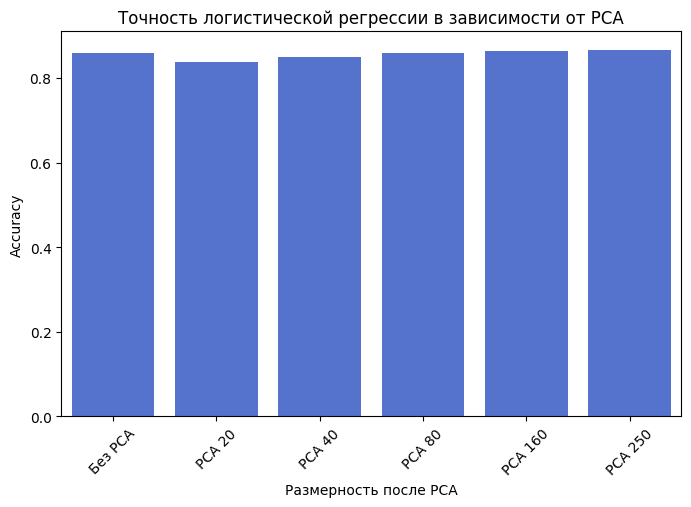

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy_results = {}

rff_model = RFFPipeline(use_PCA=False, feature_creator_class=RandomFeatureCreator)
rff_model.fit(x_train, y_train)
y_predicted = rff_model.predict(x_test)
accuracy_results['Без PCA'] = accuracy_score(y_test, y_predicted)

feature_sizes = [20, 40, 80, 160, 250]
for features in feature_sizes:
    model = RFFPipeline(new_dim=features, feature_creator_class=RandomFeatureCreator)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    accuracy_results[f'PCA {features}'] = accuracy_score(y_test, pred)

plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracy_results.keys()), y=list(accuracy_results.values()), color="royalblue")
plt.title('Точность логистической регрессии в зависимости от PCA')
plt.ylabel('Accuracy')
plt.xlabel('Размерность после PCA')
plt.xticks(rotation=45)
plt.show()

Вывод: сжатие не повышает точность, но и не особо понижает ее - на графике видно, что значеня примерно на одном уровне

__2. Зависимость качества от n_features__

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Text(0.5, 0, 'Количество признаков')

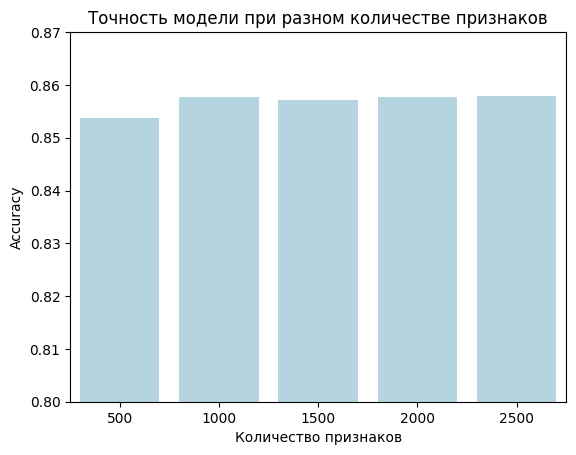

In [13]:
accuracy_results = {}
n_features = list(range(500, 3000, 500))

for n_feature in n_features:
    pipeline = RFFPipeline(n_features=n_feature, feature_creator_class=RandomFeatureCreator)
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    accuracy_results[n_feature] = accuracy_score(y_test, y_pred)

x_values = list(accuracy_results.keys())
y_values = list(accuracy_results.values())

ax = sns.barplot(x=x_values, y=y_values, color="lightblue")
ax.set(ylim=(0.8, 0.87))
ax.set_title('Точность модели при разном количестве признаков')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Количество признаков')

Вывод: при n_features = 1000 получили лучшую точность, но в целом видно, что изменение количества признаков, генерируемых RFF, не особо влияет на результат

__3. Логистическая регресся vs SVM__

 В предыдущем номере мы уже сравнивали эти модели и пришли к выводу о том, что разница между логистической регрессией и SVM незначительная. RFF + логрег показал лучшую точность, но обучался дольше, а SVM с RBF-ядром был медленнее линейного SVM, хотя немного точнее

__Задание 4. (Максимум 1.5 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет), n_features=new_dim и n_features < new_dim также должны работать, убедитесь в этом. Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.


In [13]:
from homework_practice_08_rff import OrthogonalRandomFeatureCreator

In [14]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=OrthogonalRandomFeatureCreator)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8547


Точность получилась почти такая же (на 0.0017 выше), как и при использовании RFF. По времени чуть быстрее, но тоже незначительная разница

__Задание 5. (Максимум 1 балл)__

Существует большое количество работ, где идея RFF развивается, предлагаются её обобщения (которые, по сути, выливаются в другие преобразования признаков, не обязательно уже тригонометрические). Возьмите любую из таких работ, кратко опишите идею, имплементируйте её и сравните качество с ORF и RFF, которые вы запрограммировали выше.

Ссылки на статьи, где обсуждаются вариации RFF для разных ядер, можно найти в окрестности таблицы 1 в работе https://arxiv.org/pdf/1407.5599  

___ссылка на работу:___

___описание идеи:___

In [ ]:
# Пример

__Задание 6. (Максимум 2.5 балла)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск **[1 балл максимум]**, также добавьте возможность использовать аналитическую формулу **[1 балл максимум]**. Для градиентного спуска выпишите градиент ниже **[0.5 баллов максимум]**.
Подумайте о том, как в формулах правильно учесть свободный коэффициент.

Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь:
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание:
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

___Выведите градиент:___
$$
\nabla_w Q(w) = K (K w - y) + \lambda K w
$$

Вы можете изменять представленный шаблон в файле `homework_practice_08_kernel_regression.py` по своему усмотрению.

In [1]:
from homework_practice_08_kernel_regression import KernelRidgeRegression

In [2]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=100, n_features=10, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
kernel_ridge = KernelRidgeRegression(lr=0.01, regularization=1.0)
kernel_ridge.fit(X_train, y_train)
y_pred = kernel_ridge.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)